# How to bring your own TF 2.3.1 model to SageMaker

This is a toy example to show how to train a model using TF 2.3.1 and then use it with SageMaker, for a real-time endpoint prediction or batch prediction.

This example is divided in two parts:
 - Part 1: this notebook. Here you will generate a synthetic dataset (sine wave form) and then create a simple NN that learns to predict the sine curve. You will save this model to an S3 bucket.
 - Part 2: you will get the trained model, create a SageMaker Model and then test it locally, then run a batch prediction job

In [ ]:
!pip install --upgrade --force-reinstall botocore boto3 awscli sagemaker
# remove the sufix -gpu if your local instance has not GPU
!pip install tensorflow-gpu==2.3.1

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sagemaker
from sagemaker.local import LocalSession

#sagemaker_session = LocalSession()
#sagemaker_session.config = {'local': {'local_code': True}}
sagemaker_session=sagemaker.Session()

role = sagemaker.get_execution_role()
bucket_name = sagemaker_session.default_bucket()
prefix='sine'
tf.__version__,bucket_name

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


('2.3.1', 'sagemaker-us-east-1-715445047862')

## 1) Create a synthetic dataset - Sine Wave

In [2]:
def generate_sample(samples=1000):
    # Generate a uniformly distributed set of random numbers in the range from
    # 0 to 2π, which covers a complete sine wave oscillation
    x_values = np.random.uniform(low=0, high=2*math.pi, size=samples)

    # Shuffle the values to guarantee they're not in order
    np.random.shuffle(x_values)

    # Calculate the corresponding sine values
    y_values = np.sin(x_values)

    # Add a small random number to each y value
    y_values += 0.1 * np.random.randn(*y_values.shape)
    return x_values, y_values

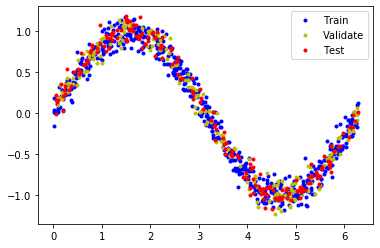

In [3]:
# We'll generate this many sample datapoints
SAMPLES = 1000

# Set a "seed" value, so we get the same random numbers each time we run this
# notebook. Any number can be used here.
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

x_values, y_values = generate_sample(SAMPLES)
    
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

### 1.1) We need to generate a bunch of files to test the batch prediction

In [11]:
%%time
import boto3

s3_client = boto3.client('s3')

for file_id in range(1000):
    with io.BytesIO() as data:
        x_values, _ = generate_sample(16000)
        for idx,x in enumerate(x_values):
            line = "%d,%.05f\n" % (idx, x)
            data.write(line.encode('utf-8'))
        data.seek(0)
        key = "%s/batch/input/file_%03d.csv" % (prefix, file_id )
        s3_client.upload_fileobj(data, bucket_name, key)

CPU times: user 25.3 s, sys: 0 ns, total: 25.3 s
Wall time: 1min 52s


## 2) Prepare/train a simple regression model

In [4]:
# We'll use Keras to create a simple model architecture
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons." The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second layer may help the network learn more complex representations
model.add(tf.keras.layers.Dense(20, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(tf.keras.layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Show a summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model.fit(x_train, y_train, epochs=150, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/150
38/38 [==============================] - 0s 7ms/step - loss: 1.0692 - mae: 0.8853 - val_loss: 0.6756 - val_mae: 0.7416
Epoch 2/150
38/38 [==============================] - 0s 3ms/step - loss: 0.5098 - mae: 0.6369 - val_loss: 0.4558 - val_mae: 0.5895
Epoch 3/150
38/38 [==============================] - 0s 3ms/step - loss: 0.3777 - mae: 0.5328 - val_loss: 0.3537 - val_mae: 0.5161
Epoch 4/150
38/38 [==============================] - 0s 3ms/step - loss: 0.3064 - mae: 0.4802 - val_loss: 0.2970 - val_mae: 0.4689
Epoch 5/150
38/38 [==============================] - 0s 3ms/step - loss: 0.2538 - mae: 0.4396 - val_loss: 0.2397 - val_mae: 0.4185
Epoch 6/150
38/38 [==============================] - 0s 3ms/step - loss: 0.2087 - mae: 0.3998 - val_loss: 0.2032 - val_mae: 0.3856
Epoch 7/150
38/38 [==============================] - 0s 3ms/step - loss: 0.1761 - mae: 0.3692 - val_loss: 0.1713 - val_mae: 0.3590
Epoch 8/150
38/38 [==============================] - 0s 3ms/step - loss: 0.1535 - m

38/38 [==============================] - 0s 3ms/step - loss: 0.0145 - mae: 0.0954 - val_loss: 0.0151 - val_mae: 0.0954
Epoch 64/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0145 - mae: 0.0947 - val_loss: 0.0184 - val_mae: 0.1101
Epoch 65/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0145 - mae: 0.0952 - val_loss: 0.0133 - val_mae: 0.0892
Epoch 66/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0144 - mae: 0.0936 - val_loss: 0.0127 - val_mae: 0.0872
Epoch 67/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0146 - mae: 0.0953 - val_loss: 0.0150 - val_mae: 0.0933
Epoch 68/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0143 - mae: 0.0944 - val_loss: 0.0125 - val_mae: 0.0874
Epoch 69/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0140 - mae: 0.0936 - val_loss: 0.0128 - val_mae: 0.0896
Epoch 70/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0140 - mae: 0

Epoch 125/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0884 - val_loss: 0.0130 - val_mae: 0.0921
Epoch 126/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0118 - mae: 0.0878 - val_loss: 0.0115 - val_mae: 0.0847
Epoch 127/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0118 - mae: 0.0872 - val_loss: 0.0118 - val_mae: 0.0859
Epoch 128/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0114 - mae: 0.0863 - val_loss: 0.0153 - val_mae: 0.0995
Epoch 129/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0123 - mae: 0.0895 - val_loss: 0.0111 - val_mae: 0.0829
Epoch 130/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.0871 - val_loss: 0.0130 - val_mae: 0.0901
Epoch 131/150
38/38 [==============================] - 0s 3ms/step - loss: 0.0117 - mae: 0.0875 - val_loss: 0.0158 - val_mae: 0.1033
Epoch 132/150
38/38 [==============================] - 0s 3ms/step - 

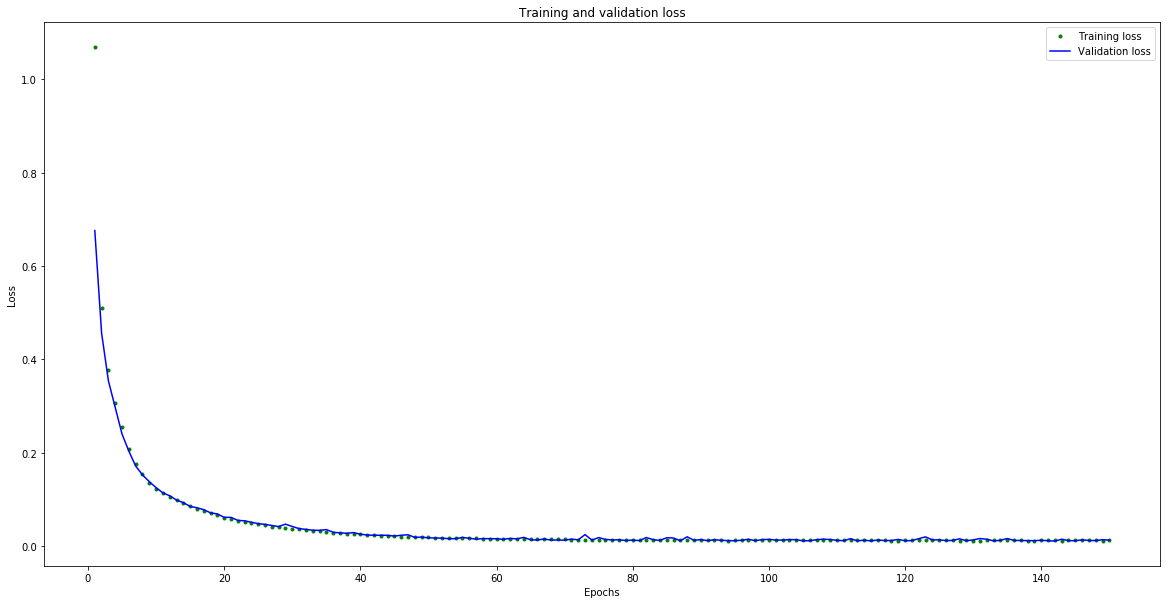

In [6]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3) Save the model package to an S3 bucket

In [7]:
import boto3
import io
import os
import tarfile

# Saving in SavedModel format (required by SM)
!rm -rf sine
model.save('sine/1')

s3_client = boto3.client('s3')
key = "%s/model.tar.gz" % prefix
with io.BytesIO() as data:
    with tarfile.open(name=None, mode="w:gz", fileobj=data) as tar_handle:
        tar_handle.add("sine")
    data.seek(0)
    s3_client.upload_fileobj(data, bucket_name, key)
print(bucket_name, key)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: sine/1/assets
sagemaker-us-east-1-715445047862 sine/model.tar.gz
